<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/08.00.Aula-Modelos_individuais_multiplas_estruturas.slides.html"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos indivuais estocásticos estruturados](07.00.Aula-Modelos_individuos_estruturados.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos individuais estocásticos com múltiplas estruturas de conexão - parte II ->](09.00.Aula-Modelos_individuais_multiplas_estruturas_2.ipynb)

---


# Modelos individuais estocásticos com múltiplas estruturas de conexão - parte I

- Continuando o estudo de **modelos estocásticos individuais espacialmente estruturados e com evolução temporal discreta.**

- Desta vez, vamos incluir **diferentes tipos de estruturas**:

    - **Local**:

        - grafo construido geometricamente, com os vértices colocados de acordo com a localização dos indivíduos e com as conexões feitas de acordo com a proximidade entre eles.

        - simulando encontros por proximidade, e.g. vizinhos, comércio local, etc.

    - **Global**:
    
        - grafo completo, mas com conexões com peso decaindo segundo a distância entre os indivíduos.
    
        - simulando encontros distantes esporádicos, e.g. no caminho para outros lugares visitados esporadicamente e em locais diversos.

    - **Social**:

        - grafo com uma certa estrutura típica de relacionamentos sociais físicos.

        - simulando relações constantes, e.g. familiares, no trabalho, na escola.

**Importando bibliotecas e definindo funções a serem usadas abaixo**

In [1]:
import datetime as dt # date and time tools

from collections import namedtuple

from os import path

import random

import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import rv_continuous

import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 29/Apr/2020


In [3]:
sns.set_style("darkgrid")

## Parâmetros

- Abaixo, definimos as taxas de $\beta$ e $\gamma$ assim como parâmetros para as simulações.

- Em particular, reduzimos o número de simulações pro modelo estocástico, para reduzir o tempo de cálculo, nessa fase inicial de investigação.

- As condições iniciais (população e número inicial de infectados) são definidas posteriormente.

In [4]:
beta = 0.5
gamma = 0.1
R0 = beta/gamma
T = 80
tempos = np.array(range(T+1))
num_sim = 10
print(f'Número básico de reprodução = {R0:.2f}')

Número básico de reprodução = 5.00


## Funções de evolução e de análise

- Reproduzimos algumas funções utilizadas na última aula para facilitar as simulações.

    - `evolucao_SIR`

    - `analise_grafo`

    - `evolucao_grafo`
    
- **Observação:** Fizemos uma alteração na função `analise_grafo()`, que é também importante na simulação, para que o cálculo do número de conexões leve o "peso" (`weight`) da aresta em consideração. Este peso influencia na probabilidade de contágio.

In [5]:
def evolucao_SIR(pop_0, beta, gamma, tempos, plot=False):

    SIR_Compartimental = namedtuple('SIR_Compartimental', 
                                 [
                                     'pop_0',
                                     'num_pop',
                                     'beta',
                                     'gamma',
                                     't_instantes',
                                     'S',
                                     'I', 
                                     'R',
                                     'X'
                                 ])        
          
    def diferencial(t, X, N, beta, gamma):
        S, I = X
        dXdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
        return dXdt        
    
    num_pop = sum(pop_0)
    y0 = pop_0[0:2]
    sol = solve_ivp(diferencial, t_span=[tempos[0],tempos[-1]], 
                    y0 = y0, t_eval = tempos,
                    args=(num_pop, beta, gamma))
    
    resultado = SIR_Compartimental(pop_0, num_pop, beta, gamma, tempos,
                                   sol.y[0], sol.y[1], num_pop - sol.y[0] - sol.y[1], sol)
    return resultado

In [6]:
def analise_grafo(G, info=True, node_size=0, pos=None, hist=False):

    num_vertices = G.number_of_nodes()
    num_arestas = G.number_of_edges() # usado na versão antiga
    num_arestas_weighted = G.size(weight='weight') # usado na versão atual
    num_arestas_por_vertice_weighted = [j for i,j in G.degree(weight='weight')]
    num_medio_conexoes = 2*num_arestas_weighted/num_vertices
    num_medio_conexoes = sum([d[1] for d in G.degree(weight='weight')])/G.number_of_nodes()

    if info:
        print(f'Número de vértices: {num_vertices}')
        print(f'Número de arestas: {num_arestas}')
        print(f'Número de arestas com peso: {num_arestas_weighted}')
        print(f'Número médio de conexões por indivíduo: {num_medio_conexoes:.1f}')

    if node_size:
        color = ['tab:blue', 'tab:red', 'tab:green']
        pop_estado = nx.get_node_attributes(G,'estado')
        color_map = [color[pop_estado[j]-1] for j in range(num_vertices)]
        plt.figure(figsize=(10,6))
        if pos:
            nx.draw(G, pos, node_size=node_size, node_color=color_map, alpha=0.5)
        else:
            nx.draw(G, node_size=node_size, node_color=color_map, alpha=0.5)
        plt.title('Rede de indivíduos e de suas conexões', fontsize=16)
        plt.show()

    if hist:
        plt.figure(figsize=(10,6))
        plt.hist(num_arestas_por_vertice_weighted, 50, facecolor='g', alpha=0.75)
        plt.xlabel('num. arestas', fontsize=14)
        plt.ylabel('num. vertices', fontsize=14)
        plt.title('Histograma com a quantidade de indivíduos por número de conexões', fontsize=16)
        plt.show()
    return num_medio_conexoes

In [7]:
def evolucao_grafo_estruturado(pop_0, tau, gamma, G, tempos, num_sim, show=''):
    """Evolução temporal da epidemia em um grafo estruturado.


    Entrada:
        pop_0: numpy.array
            state of the population, with 
                1: suscetível
                2: infectado
                3: recuperado ou removido

        tau: float
            probabilidade de contágio por contato

        gamma: float
            taxa de recuperação por unidade de tempo

        G: numpy.array
            grafo de conexões

        tempos: numpy.array
            instantes de tempo

        num_sim: int
            número de simulações

        show: str
            indica se é para exibir um gráfico e de que tipo:
                - 'nuvem': exibe uma nuvem com todas as simulações e o valor médio em destaque
                - 'sd': exibe o valor médio com uma faixa dada pelo desvio padrão
                - 'sdc': exibe o valor médio com uma faixa dada pelo desvio padrão corrigido
                - '68%': exibe o valor médio com uma faixa dada pelo intervalo de confiança de 68%
                - '95%': exibe o valor médio com uma faixa dada pelo intervalo de confiança de 95%
                - 'medio': exibe apenas o valor médio
                - '': não exibe gráfico algum.

    Saída
        X: class.SIR_Individual
            Uma instância da classe `SIR_Individual` com os seguintes atributos:
                pop_0:
                num_pop:
                tau:
                gamma:
                G:
                tempos:
                num_sim:
                S_mean:
                I_mean: 
                R_mean:
                I_sigma:
                R_sigma:
                S_sigma:
    """

    def passo_grafo_estruturado(num_pop, populacao, A_adj, prob_infeccao, prob_recuperacao):
        
        # gera uma matriz cheia aleatória (números em [0.0,1.0))
        A_random = np.random.rand(num_pop, num_pop)
        
        # filtra de acordo com as conexões
        A_graph_random = np.multiply(A_adj, A_random)
        
        # copia a população (acho que é desnecessário)
        pop_aux = np.copy(populacao)
        
        # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
        pop_suscetiveis = np.select([pop_aux==1], [pop_aux])
        
        # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectável
        pop_infectados = np.select([pop_aux==2], [pop_aux])/2
        
        # cria uma matriz de risco, mantendo apenas as conexões que envolvem um infectado
        A_risco = np.multiply(np.tile(pop_infectados, (num_pop, 1)), A_graph_random)
        
        # cria matriz de contatos entre um suscetível e um infectado
        A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_pop, 1)).transpose(), A_risco)
        
        # cria uma matriz de 1's e 0's, indicando se houve, ou não, contágio
        A_infectados = np.select([A_contatos > 1-prob_infeccao], [np.ones([num_pop, num_pop])])

        # obtém novos infectados
        pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_pop)])
        
        # filtra matriz aleatória com a diagonal
        pop_recuperando = pop_infectados @ np.multiply(np.eye(num_pop), A_random)
        
        # obtém novos recuperados
        pop_novos_recuperados = np.select([pop_recuperando > 1-prob_recuperacao], [np.ones(num_pop)])
        
        # atualiza população adicionando um aos que avançaram de estágio
        populacao_nova = pop_aux + pop_novos_infectados + pop_novos_recuperados

        # Observe que cada elemento da matriz aleatória é usado apenas uma vez, garantindo
        # a independência desses eventos aleatórios (tanto quanto se leve em consideração
        # que os números gerados são pseudo-aleatórios)

        return populacao_nova

    
    # confere se escolha para `show` é válida
    if show:
        assert(show in ('nuvem', 'sd', '68%', '95%', 'media')), 'Valor inválido para argumento `show`.'

    # atributos de saída
    SIR_Individual = namedtuple('SIR_Individual', 
                                [
                                    'pop_0',
                                    'num_pop',
                                    'tau',
                                    'gamma',
                                    'G',
                                    'tempos',
                                    'num_sim',
                                    'S_mean',
                                    'I_mean', 
                                    'R_mean',
                                    'S_sigma',
                                    'I_sigma', 
                                    'R_sigma',
                                    'S_erro_padrao',
                                    'I_erro_padrao', 
                                    'R_erro_padrao'
                                ])
    
    # número de indivíduos da população
    num_pop = len(pop_0)
    I_0 = np.count_nonzero(pop_0==2)        

    # número de instantes no tempo e passos de tempo 
    num_t = len(tempos)
    passos_de_tempo = tempos[1:] - tempos[:-1]

    # inicializa variáveis para o cálculo da média
    S_mean = np.zeros(num_t)
    I_mean = np.zeros(num_t)
    R_mean = np.zeros(num_t)

    # inicializa variáveis para o cálculo do desvio padrão
    S_sigma = np.zeros(num_t)
    I_sigma = np.zeros(num_t)
    R_sigma = np.zeros(num_t)
    
    # obtém matriz de adjacências e o número médio de vizinhos do grafo
    A_adj = nx.to_numpy_matrix(G)

    # prepara gráfico se necessário
    if show:    
        # inicializa figura e define eixo vertical
        plt.figure(figsize=(12,6))
        plt.ylim(0, num_pop)
        plt.xlim(tempos[0], tempos[-1])
    
    if show == 'nuvem':
        # alpha para a nuvem de gráficos das diversas simulaçõe
        alpha = min(0.2, 5/num_sim)    

    # simulações
    for j in range(num_sim):

        # inicializa população de cada simulação
        populacao = np.copy(pop_0)
        S = np.array([num_pop - I_0])
        I = np.array([I_0])
        R = np.array([0])
     
        
        # evolui o dia e armazena as novas contagens
        for dt in passos_de_tempo:

            # calcula probabilidades
            prob_infeccao = 1 - np.exp(-tau*dt)
            prob_recuperacao = 1 - np.exp(-gamma*dt)

            populacao = passo_grafo_estruturado(num_pop, populacao, A_adj,
                                                prob_infeccao, prob_recuperacao)
            S = np.hstack([S, np.count_nonzero(populacao==1)])
            I = np.hstack([I, np.count_nonzero(populacao==2)])
            R = np.hstack([R, np.count_nonzero(populacao==3)])
            
        # adiciona as contagens dessa simulação para o cálculo final da média
        S_mean += S
        I_mean += I
        R_mean += R

        # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
        S_sigma += S ** 2
        I_sigma += I ** 2
        R_sigma += R ** 2

        if show == 'nuvem':
            # exibe os gráficos dos dados de cada simulação
            plt.plot(tempos, S, '-', color='tab:green', alpha=alpha)
            plt.plot(tempos, I, color='tab:red', alpha=alpha)
            plt.plot(tempos, R, '-', color='tab:blue', alpha=alpha)
            plt.plot(tempos, num_pop - S, '-', color='tab:gray', alpha=alpha)

    # divide pelo número de evoluções para obter a média
    S_mean /= num_sim
    I_mean /= num_sim
    R_mean /= num_sim

    # ajusta o calcula do desvio padrão
    S_sigma = ( S_sigma / num_sim - S_mean**2 )**.5
    I_sigma = ( I_sigma / num_sim - I_mean**2 )**.5
    R_sigma = ( R_sigma / num_sim - R_mean**2 )**.5
    
    S_sigma_cor = ( num_sim * S_sigma**2 / (num_sim - 1) )**.5
    I_sigma_cor = ( num_sim * I_sigma**2 / (num_sim - 1) )**.5
    R_sigma_cor = ( num_sim * R_sigma**2 / (num_sim - 1) )**.5
    
    S_erro_padrao = S_sigma_cor / num_sim**.5
    I_erro_padrao = I_sigma_cor / num_sim**.5
    R_erro_padrao = R_sigma_cor / num_sim**.5

    # exibe os gráficos das médias
    if show == 'sd':
        plt.fill_between(tempos, S_mean - S_sigma, S_mean + S_sigma, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_sigma, I_mean + I_sigma, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_sigma, R_mean + R_sigma, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_sigma, num_pop - S_mean + S_sigma, facecolor='tab:gray', alpha = 0.2)
        
    if show == '68%':
        plt.fill_between(tempos, S_mean - S_erro_padrao, S_mean + S_erro_padrao, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_erro_padrao, I_mean + I_erro_padrao, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_erro_padrao, R_mean + R_erro_padrao, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_erro_padrao, num_pop - S_mean + S_erro_padrao, facecolor='tab:gray', alpha = 0.2)

    if show == '95%':
        plt.fill_between(tempos, S_mean - 2*S_erro_padrao, S_mean + 2*S_erro_padrao, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - 2*I_erro_padrao, I_mean + 2*I_erro_padrao, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - 2*R_erro_padrao, R_mean + 2*R_erro_padrao, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - 2*S_erro_padrao, num_pop - S_mean + 2*S_erro_padrao, facecolor='tab:gray', alpha = 0.2)

    if show:
        plt.plot(tempos, S_mean, '-', color='tab:green', label='suscetíveis')
        plt.plot(tempos, I_mean, '-', color='tab:red', label='infectados')
        plt.plot(tempos, R_mean, '-', color='tab:blue', label='recuperados')
        plt.plot(tempos, num_pop - S_mean, '-', color='tab:gray', label='inf.+ rec.')
        
    if show == 'nuvem':
        plt.title('Evolução do conjunto de simulações e da média', fontsize=16)
    elif show == 'sd':
        plt.title('Evolução da média, com o desvio padrão', fontsize=16)
    elif show == '68%':
        plt.title('Evolução da média, com intervalo de confiança de 68%', fontsize=16)
    elif show == '95%':
        plt.title('Evolução da média, com intervalo de confiança de 95%', fontsize=16)
    elif show == 'media':
        plt.title('Evolução da média das simulações', fontsize=16)

        
    # informações para o gráfico
    if show:
        plt.xlabel('tempo', fontsize=14)
        plt.ylabel('número de indivíduos', fontsize=14)
        plt.legend(fontsize=12)
        plt.show() 

    resultado = SIR_Individual(
        pop_0,
        num_pop,
        tau,
        gamma,
        G,
        tempos,
        num_sim,
        S_mean,
        I_mean, 
        R_mean,
        I_sigma,
        R_sigma,
        S_sigma,
        S_erro_padrao,
        I_erro_padrao, 
        R_erro_padrao
    )

    return resultado

## Construindo camadas de redes (grafos) de conexões

O modelo é baseado na separação de diversas estruturas de conexões:

- Rede local.

- Rede global.

- Rede social.

### Rede local

Construimos essa rede com os seguintes passos:

1. Dividimos o espaço em áreas retangulares.

2. Definimos a população em cada área dessas.

3. Posicionamos os indivíduos, aleatoriamente, em cada área correspondente, de acordo com a população em cada área dessas.

4. Essas posições vão para uma variável do tipo `dict`, onde a chave é o número do indivíduo/vértice e o valor é uma `tuple` com as duas coordenadas espaciais de cada indivíduo.

5. Finalmente, criamos a rede com a função [nx.random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.random_geometric_graph.html). Outra opção é [nx.thresholded_random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.thresholded_random_geometric_graph.html), que é equivalente ao anterior quando o seu argumento `theta` daquele é igual a 0, exceto que ela ainda confere um "peso" ao vértice.

6. Essa rede faz conexões segundo a proximididade e uma certa probabilidade ocorrência.

#### Habitantes por área

Primeiro, definimos uma matriz representando o número de habitantes por "bairro", ou área retângular, mais precisamente.

In [8]:
densidade = np.array(
    [[16, 11, 0, 0,  0,  6,  4,  8,  8,  6],
     [10, 12, 12, 6, 8, 9,  8,  6,  7,  5],
     [0, 10, 14, 10, 12,  8,  0,  0,  6,  8],
     [0, 12, 10, 14, 11,  9,  0,  0,  5,  7],
     [9, 11, 0, 12, 10,  7,  8,  7,  8, 0]
    ])

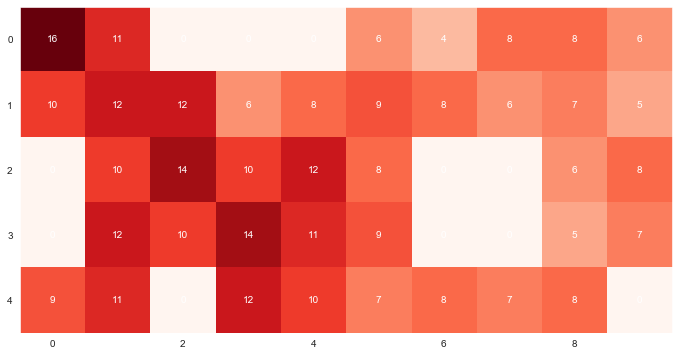

In [9]:
plt.figure(figsize=(12,6))
plt.imshow(densidade, cmap='Reds', interpolation='nearest')
N, M = densidade.shape
for i in range(N):
    for j in range(M):
        plt.text(j, i, densidade[i, j],
                 ha="center", va="center", color="w")
plt.grid(False)
plt.show()

#### Distribuição da população

Em seguida, distribuímos os habitantes aleatoriamente segundo a divisão populacional por área retangular.

In [10]:
np.random.seed(seed = 127)
attr_pos = dict()
k = 0
for m in range(M):
    for n in range(N):
        for i in range(densidade[n,m]):
            attr_pos.update({k: [m + np.random.rand(), N - n + np.random.rand()]})
            k += 1
num_pop = k

#### Estado inicial da população

Com base nessa população inicial, definimos quantos e quais indivíduos estão infectados.

In [11]:
# estado inicial da população
np.random.seed(seed = 342)
I_0 = 6
pop_0 = np.ones(num_pop)
infectados_0 = np.random.choice(num_pop, I_0, replace=False)
pop_0[infectados_0] = 2*np.ones(I_0)

#### Construção da rede

Finalmente, construimos a rede.

Número de vértices: 350
Número de arestas: 1536
Número de arestas com peso: 1536.0
Número médio de conexões por indivíduo: 8.8


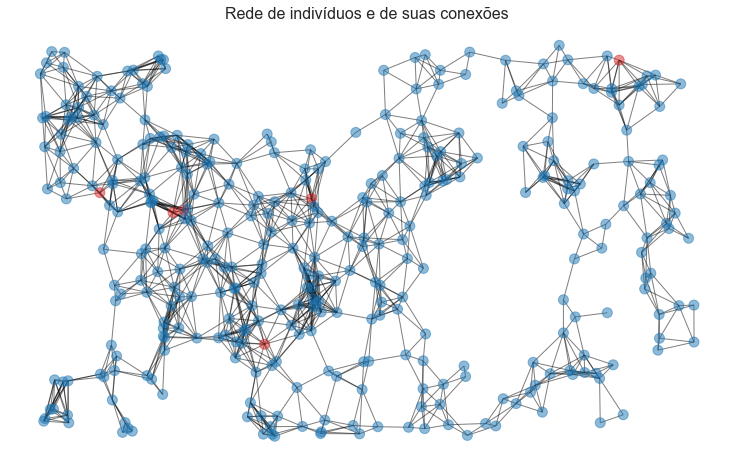

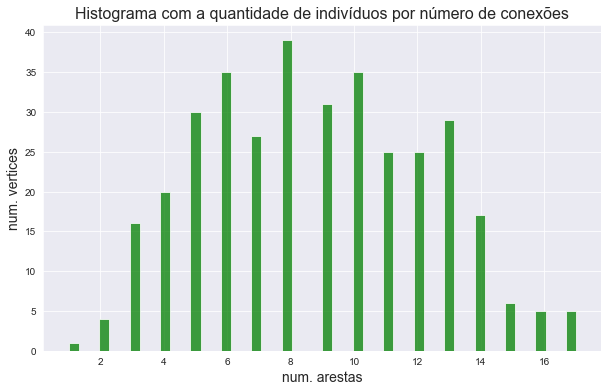

In [12]:
G_l = nx.random_geometric_graph(num_pop, 0.6, pos=attr_pos, seed=1327)
#G_l = nx.thresholded_random_geometric_graph(num_pop, 0.62, theta = 0.2, pos=attr_pos, seed=1727)

attr_estado_0 = dict([(i, {'estado': int(pop_0[i])}) for i in range(num_pop)])
nx.set_node_attributes(G_l, attr_estado_0)

nx.set_edge_attributes(G_l, 1, 'weight')

num_medio_conexoes_l = analise_grafo(G_l, info=True, node_size=100, pos=attr_pos, hist=True)

#### Informações

Podemos ver a posição de um indivíduo e o seu estado através do método `nodes`:

In [13]:
i = 9
print(f"Posição do indivíduo número {i+1}: {G_l.nodes[i]['pos']}")
print(f"Estado do indivíduo número {i+1}: {G_l.nodes[i]['estado']}")
print(f"Todos os atribudos juntos: {G_l.nodes(data=True)[i]}")

Posição do indivíduo número 10: [0.09418384564725635, 5.632883626745923]
Estado do indivíduo número 10: 1
Todos os atribudos juntos: {'pos': [0.09418384564725635, 5.632883626745923], 'estado': 1}


### Rede global

Agora, construímos uma rede completa, usando a localização dos indivíduos feita na construção do grafo geométrico, mas com conexões com peso decaindo de acordo com a distância entre os indivíduos.

In [14]:
G_g = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_g, attr_estado_0)

dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))
#
# kernel function from Keeling & Rohani (2007)
# kernel = lambda d: d**-2.6
#
# kernel function from Ferguson et al (2005), but with different parameter values
a = 1 #
b = 1.5 #
kernel = lambda d: 1.0/(1.0 + (d/a)**b)
#
attr = [(i, j, {'weight': kernel(dist(attr_pos[i], attr_pos[j]))}) for i in range(num_pop) for j in range(num_pop) if j != i]
G_g.add_edges_from(attr)

#### Análise da rede

Número de vértices: 350
Número de arestas: 61075
Número de arestas com peso: 9027.576708599296
Número médio de conexões por indivíduo: 51.6


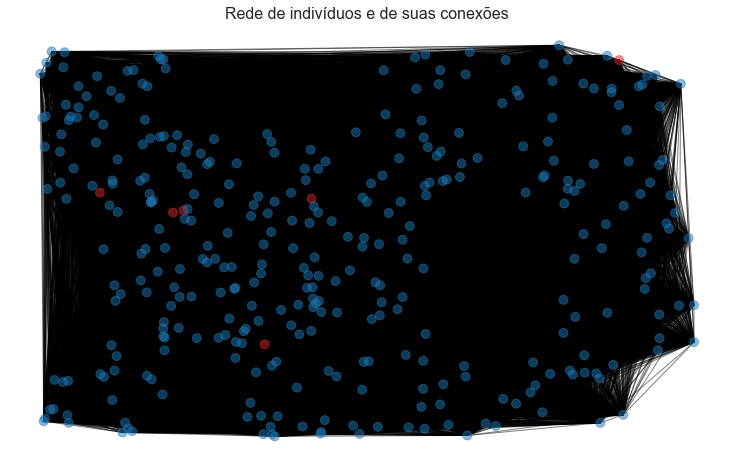

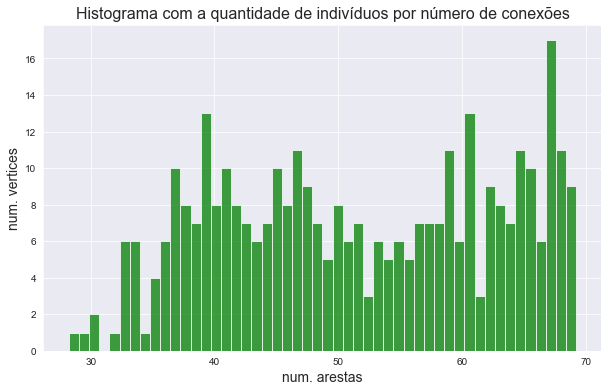

In [15]:
num_medio_conexoes_g = analise_grafo(G_g, info=True, node_size=80, pos=attr_pos, hist=True)

#### Informações

In [16]:
i = 9
print(f"Atributos do indivíduo número {i}: {G_g.nodes[i]}")
print(f"Conexões do indivíduo número {i}:")

Atributos do indivíduo número 9: {'pos': [0.09418384564725635, 5.632883626745923], 'estado': 1}
Conexões do indivíduo número 9:


### Rede social

- Lugares de trabalho e escolas têm a propriedade de congregar diversos indivíduos.

- Simulamos isso selecionando indivíduos aleatoriamento e conectando todos entre si.

- É claro que indivíduos em um mesmo local de trabalho ou escola tendem a formar grupos, com elos mais fortes, mas nesse primeiro momento não vamos implementar isso.

- De qualquer forma, esses grupos podem ser modelados através de pesos nas conexões.

- Diferentes trabalhos também acarretam em conexões entre alguns de seus indivíduos, mas também não vamos implementar isso.

- Naturalmente, nem todos participam de grupos assim (e.g. bebês, desempregados, aposentados), então nem todos serão selecionados neste processo.

#### Tamanho dos lugares

Em [Ferguson et al (2005)](#Referências), é mencionado que o tamanho, em número de trabalhadores, dos lugares de trabalho também satisfaz uma lei de potência.

Aqui, não vamos nos preocupar muito com a forma exata dessa distribuição.

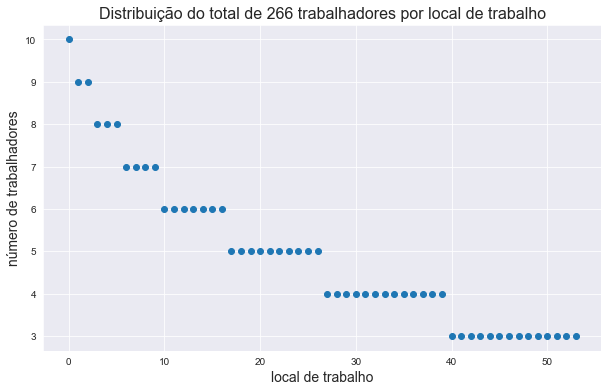

In [17]:
rs_tamanho = [10, 9, 9, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
           5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
#print('Total de indivíduos nos lugares de trabalho/escola:', )
plt.figure(figsize=(10,6))
plt.plot(rs_tamanho, 'o')
plt.xlabel('local de trabalho', fontsize=14)
plt.ylabel('número de trabalhadores', fontsize=14)
plt.title(f'Distribuição do total de {sum(rs_tamanho)} trabalhadores por local de trabalho', fontsize=16)
plt.show()

#### Construção da rede

In [18]:
G_s = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_s, attr_estado_0)
random.seed(721)
pop_index = list(range(num_pop))
membros = dict()

for j in range(len(rs_tamanho)):
    individuos_aleatorios = random.sample(pop_index, rs_tamanho[j])
    for i in individuos_aleatorios:
        pop_index.remove(i)
    membros.update({j: individuos_aleatorios})
    conexoes = [(m,n) for m in individuos_aleatorios for n in individuos_aleatorios if m != n ]
    G_s.add_edges_from(conexoes)

nx.set_edge_attributes(G_s, 1, 'weight')

#### Análise da rede

Número de vértices: 350
Número de arestas: 610
Número de arestas com peso: 610.0
Número médio de conexões por indivíduo: 3.5


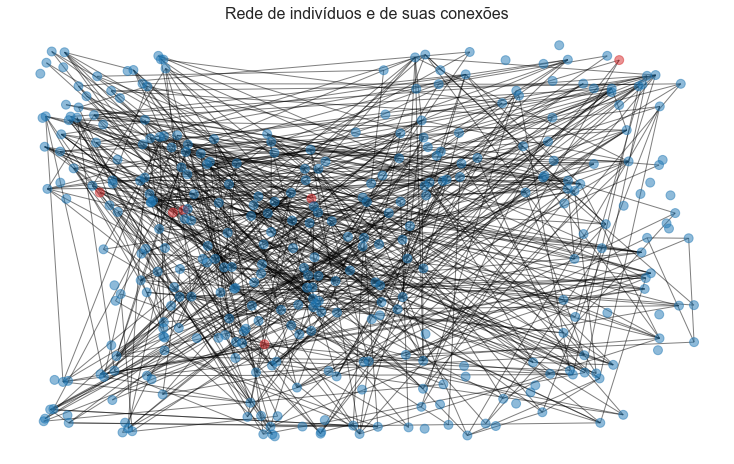

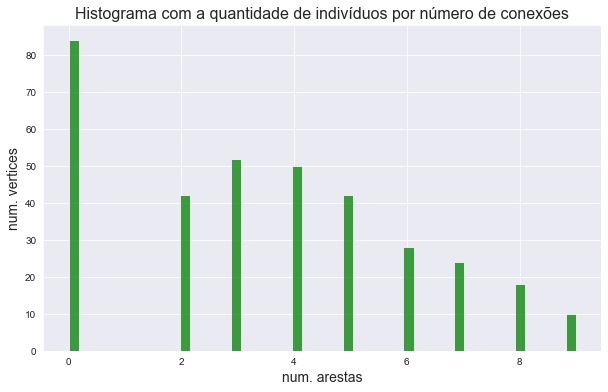

In [19]:
num_medio_conexoes_s = analise_grafo(G_s, info=True, node_size=80, pos=attr_pos, hist=True)

## Combinando as rede

- Aqui, combinamos as redes com a função [nx.compose_all](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.operators.all.compose_all.html):

```python
G_a = nx.compose_all([G_g, G_s, G_l])
``` 

- Essa função é uma união de vértices e arestas, com a propriedade de incluir todos os atributos correspondentes.

- É importante observar que, se um atributo está presente em mais de um vértice ou aresta, então o atributo do último da lista é selecionado.

- Isso é suficiente no nosso caso, em que `weight`só não é igual a 1 na rede global, que colocamos, então, como primeiro da lista.

- No entanto, caso mais de um grafo tenha o atributo `weight` da aresta com valor diferente de 1, temos que modificar o código para calcular o valor máximo.

- Uma opção de modificação, não muito eficiente, é a seguinte:

```python
G_a = nx.compose_all([G_g, G_s, G_l])
for (u,v,w) in G_s.edges.data('weight', default=0):
    if (u,v) not in G_a.edges:
        G_a.add_edge(u,v,weight=w)
    elif w > G_a.edges[u,v]['weight']:
        G_a.edges[u,v]['weight'] = w

for (u,v,w) in G_l.edges.data('weight', default=0):
    if (u,v) not in G_n.edges:
        G_a.add_edge(u,v,weight=w)
    elif w > G_a.edges[u,v]['weight']:
        G_a.edges[u,v]['weight'] = w
``` 

In [20]:
G_a = nx.compose_all([G_g, G_s, G_l])

Número de vértices: 350
Número de arestas: 61075
Número de arestas com peso: 9932.786074738005
Número médio de conexões por indivíduo: 56.8


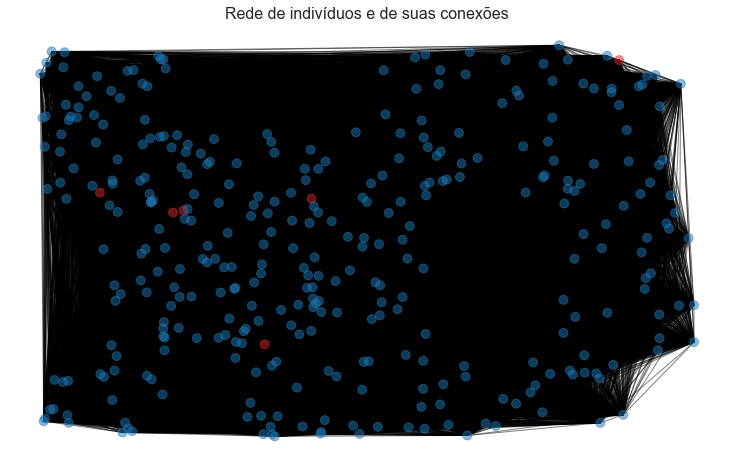

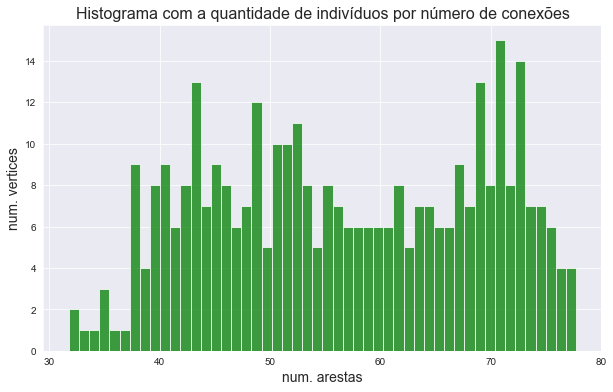

In [21]:
num_medio_conexoes_a = analise_grafo(G_a, info=True, node_size=80, pos=attr_pos, hist=True)

## Simulações

### Apenas a rede local

8.777142857142858


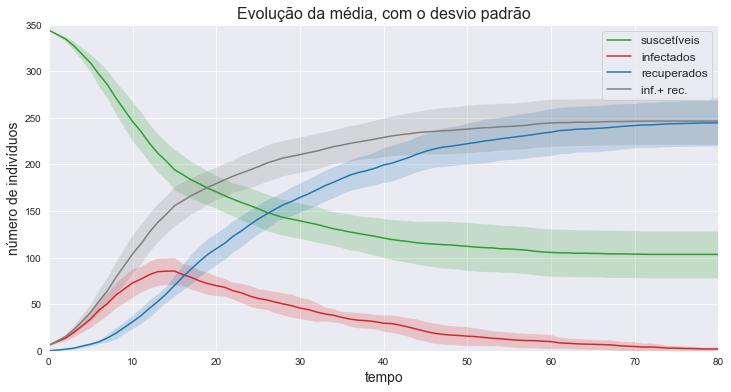

In [22]:
num_medio_conexoes_l = analise_grafo(G_l, False)
print(num_medio_conexoes_l)
X_l = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_l, gamma, G_l, tempos,
                                 num_sim, show='sd')

In [29]:
max(X_l.I_mean)

85.6

### Apenas a rede global

51.586152620567404


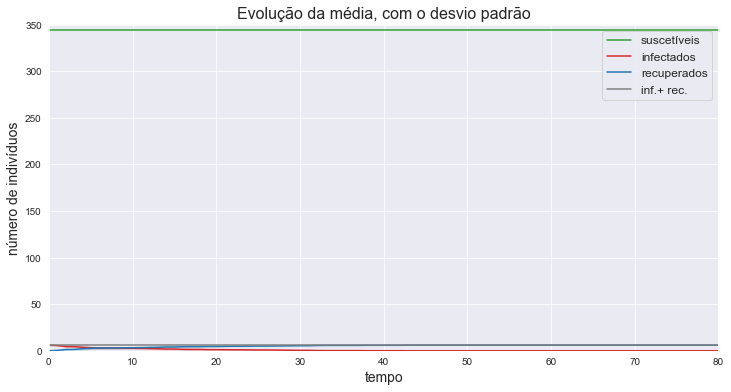

In [24]:
num_medio_conexoes_g = analise_grafo(G_g, False)
print(num_medio_conexoes_g)
X_g = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_g, gamma, G_g, tempos,
                                 num_sim, show='sd')

### Apenas a rede social

3.4857142857142858


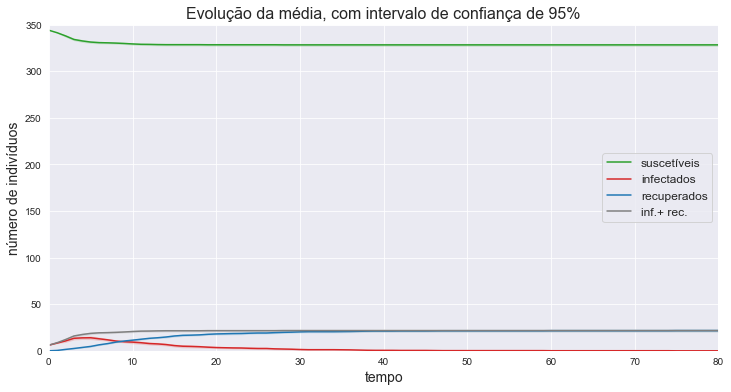

In [25]:
num_medio_conexoes_s = analise_grafo(G_s, False)
print(num_medio_conexoes_s)
X_s = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_s, gamma, G_s, tempos,
                                 num_sim, show='95%')

### Rede combinada

56.75877756993146


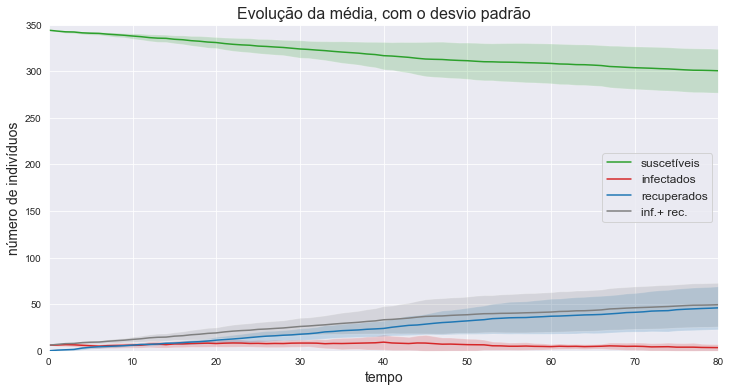

In [26]:
num_medio_conexoes_a = analise_grafo(G_a, False)
print(num_medio_conexoes_a)
X_a = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_a, gamma, G_a, tempos,
                                 num_sim, show='sd')

### Comparação com o SIR compartimental

In [27]:
X = evolucao_SIR(pop_0 = [num_pop-I_0, I_0, 0], beta=beta, gamma=gamma, tempos = tempos)

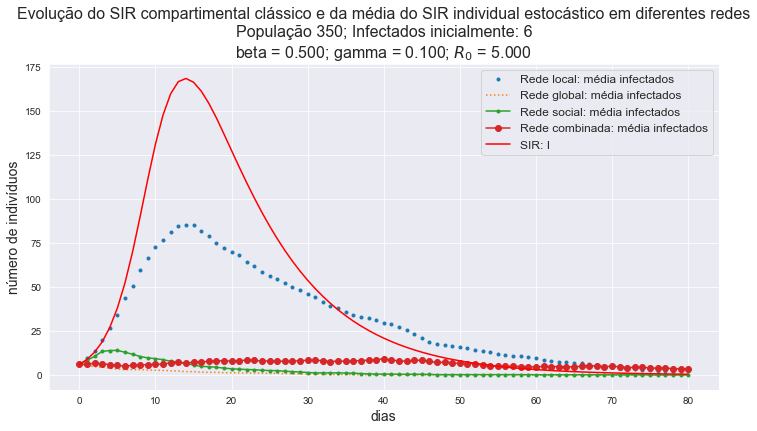

In [28]:
plt.figure(figsize=(12,6))
#plt.ylim(0, num_pop/2)

# exibe os gráficos das médias
plt.plot(tempos, X_l.I_mean, '.', label='Rede local: média infectados')
plt.plot(tempos, X_g.I_mean, ':', label='Rede global: média infectados')
plt.plot(tempos, X_s.I_mean, '.-', label='Rede social: média infectados')
plt.plot(tempos, X_a.I_mean, 'o-', label='Rede combinada: média infectados')
plt.plot(tempos, X.I, 'red', label='SIR: I')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do SIR compartimental clássico e da média do SIR individual estocástico em diferentes redes\n'
          + f'População {num_pop}; Infectados inicialmente: {I_0}\n'
          + f'beta = {beta:.3f}; gamma = {gamma:.3f}; $R_0$ = {beta/gamma:.3f}', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Trabalho 8

**Questões:**

1. Considerando a lei de potência do núcleo de decaimento em função da distância e usando a distribuição geoespacial apresentada no texto, busque parâmetros para que o modelo envolvendo apenas a rede de distância gere uma situação de epidemia.

1. Busque uma forma de gerar uma rede do tipo de local de trabalho que, por si só (sem combinar com as outras redes), gere uma situação de epidemia.

1. Busque os dados de habitantes por bairro do Rio de Janeiro, classificadas por Região Administrativa.

1. Crie uma função de construção de rede espacial tendo como argumento a Região Administrativa e um certo número de referência e retornando uma rede seguindo a linha do que foi feito acima, com os blocos divididos por bairro dentro dessa Região Administrativa e colocando, em cada bairro, um indivíduo para cada múltiplo do número de referência de habitantes de cada bairro (e.g. por mil habitantes, 100 mil habitantes, etc.).

1. Leia os artigos mencionados no texto visando identificar maneiras de melhorar, ou corrigir, o modelo aqui apresentado. Em particular, vejam o relatório do Imperial College, os artigos Ferguson et al (2005) e (2006) e Halloran et al (2008).

1. Pense em maneiras de como adaptar o modelo para incluir a quarentena e, com base nisso, implemente uma versão individual do modelo SEIR-QAD. 

1. Compare esse modelo como SEIR-QAD compartimental.

# Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020 (Free Download).](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2).

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic
in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).

- [Halloran ME, Ferguson NM, Eubank S, et al (2008), Modeling targeted layered containment of an influenza pandemic in the United States. Proc Natl Acad Sci U S A 105 (12), 4639–44 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/18332436/); veja, também, o [suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1).

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)

- [I. Z. Kiss, J. Miller & P. L. Simon (2017), Mathematics of Epidemics on Networks: From Exact to Approximate Models, Springer-Verlag.](https://www.springer.com/br/book/9783319508047)

Veja a página [Imperial College - Covid 19](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/) para mais relatórios, publicações e outras informações do Imperial College.

<!--NAVIGATOR-->

---
[<- Modelos indivuais estocásticos estruturados](07.00.Aula-Modelos_individuos_estruturados.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos individuais estocásticos com múltiplas estruturas de conexão - parte II ->](09.00.Aula-Modelos_individuais_multiplas_estruturas_2.ipynb)